In [1]:
import numpy as np

def get_kernel_size(factor):
    """
    Find the kernel size given the desired factor of upsampling.
    """
    return 2 * factor - factor % 2


def upsample_filt(size):
    """
    Make a 2D bilinear kernel suitable for upsampling of the given (h, w) size.
    """
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)


def bilinear_upsample_weights(factor, number_of_classes):
    """
    Create weights matrix for transposed convolution with bilinear filter
    initialization.
    """
    
    filter_size = get_kernel_size(factor)
    
    weights = np.zeros((filter_size,
                        filter_size,
                        number_of_classes,
                        number_of_classes), dtype=np.float32)
    
    upsample_kernel = upsample_filt(filter_size)
    
    for i in xrange(number_of_classes):
        
        weights[:, :, i, i] = upsample_kernel
    
    return weights

In [2]:
%matplotlib inline

from __future__ import division

import os
import sys
import tensorflow as tf
import skimage.io as io
import numpy as np

sys.path.append("/home/tingwei/All/Machine_Learning/Image_Segmentation/models/slim")
checkpoints_dir = '/home/tingwei/All/Machine_Learning/Image_Segmentation/checkpoints'

image_filename = 'data/imgs/cat.jpg'
annotation_filename = 'data/imgs/cat_annotation.png'

image_filename_placeholder = tf.placeholder(tf.string)
annotation_filename_placeholder = tf.placeholder(tf.string)
is_training_placeholder = tf.placeholder(tf.bool)

feed_dict_to_use = {image_filename_placeholder: image_filename,
                    annotation_filename_placeholder: annotation_filename,
                    is_training_placeholder: True}

image_tensor = tf.read_file(image_filename_placeholder)
annotation_tensor = tf.read_file(annotation_filename_placeholder)

image_tensor = tf.image.decode_jpeg(image_tensor, channels=3)
annotation_tensor = tf.image.decode_png(annotation_tensor, channels=1)

# Get ones for each class instead of a number -- we need that
# for cross-entropy loss later on. Sometimes the groundtruth
# masks have values other than 1 and 0. 
class_labels_tensor = tf.equal(annotation_tensor, 1)
background_labels_tensor = tf.not_equal(annotation_tensor, 1)

# Convert the boolean values into floats -- so that
# computations in cross-entropy loss is correct
bit_mask_class = tf.to_float(class_labels_tensor)
bit_mask_background = tf.to_float(background_labels_tensor)

combined_mask = tf.concat(axis=2, values=[bit_mask_class,
                                                bit_mask_background])

# Lets reshape our input so that it becomes suitable for 
# tf.softmax_cross_entropy_with_logits with [batch_size, num_classes]
flat_labels = tf.reshape(tensor=combined_mask, shape=(-1, 2))

INFO:tensorflow:Restoring parameters from /home/tingwei/All/Machine_Learning/Image_Segmentation/checkpoints/vgg_16.ckpt


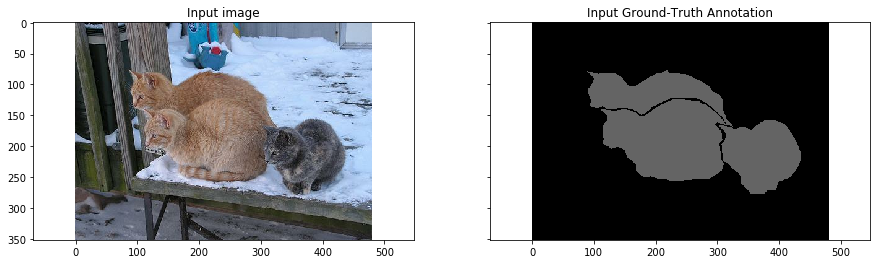

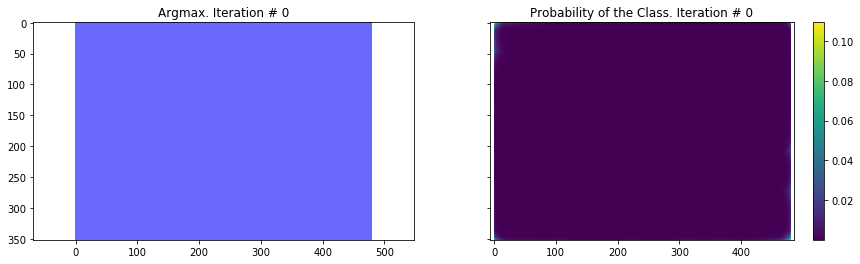

Current Loss: 257749.0


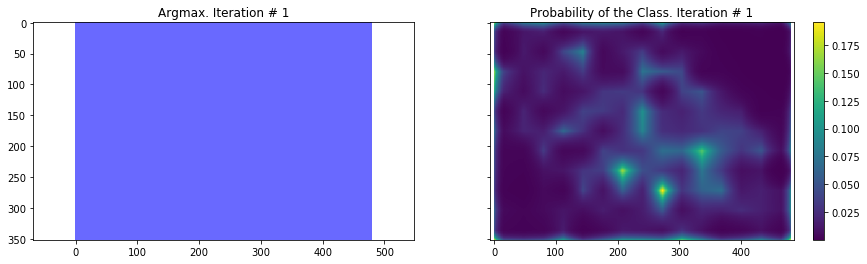

Current Loss: 579014.0


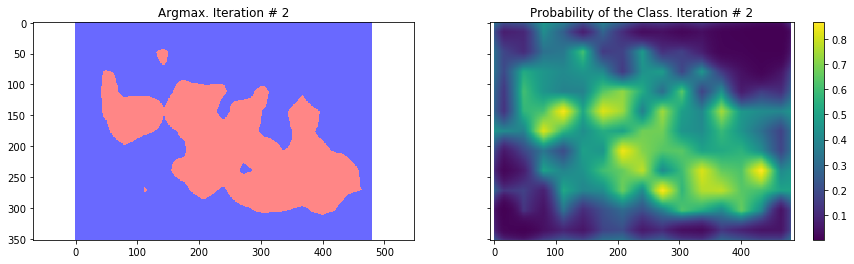

Current Loss: 149898.0


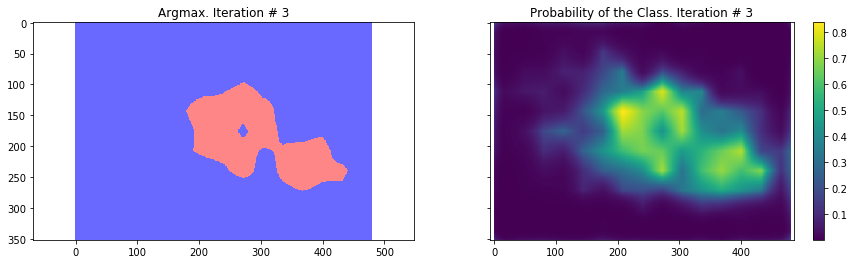

Current Loss: 68527.5


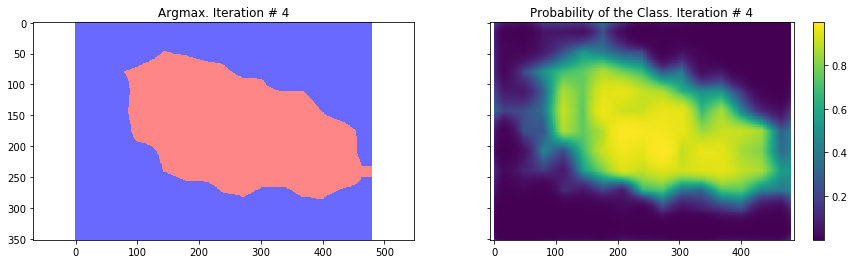

Current Loss: 47549.7


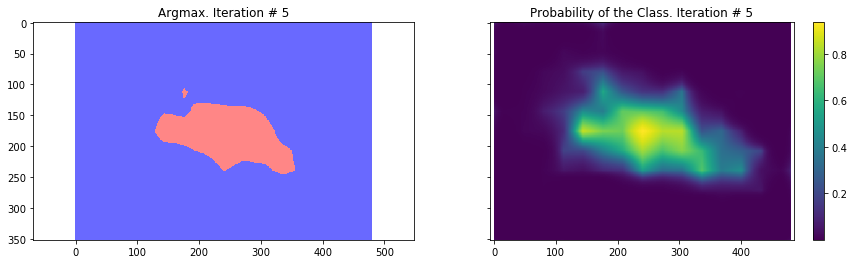

Current Loss: 43499.8


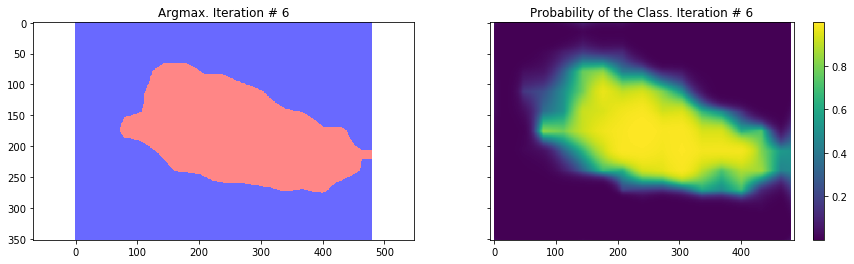

Current Loss: 51237.5


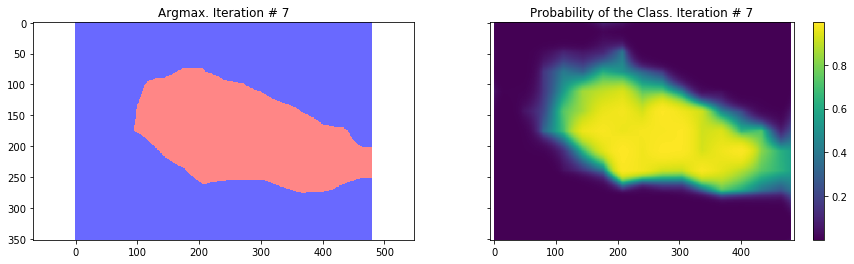

Current Loss: 30341.6


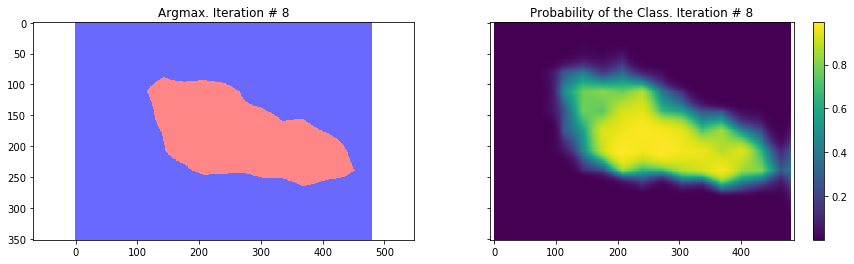

Current Loss: 30335.3


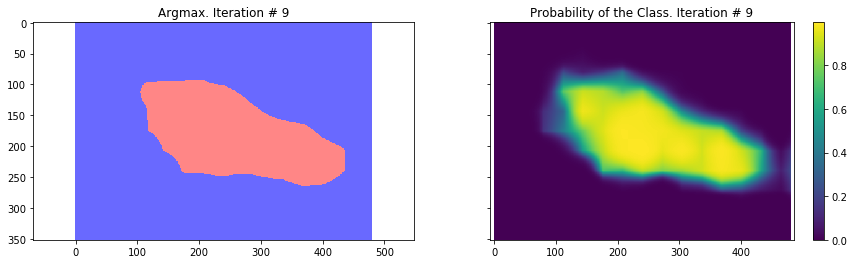

Current Loss: 26013.3


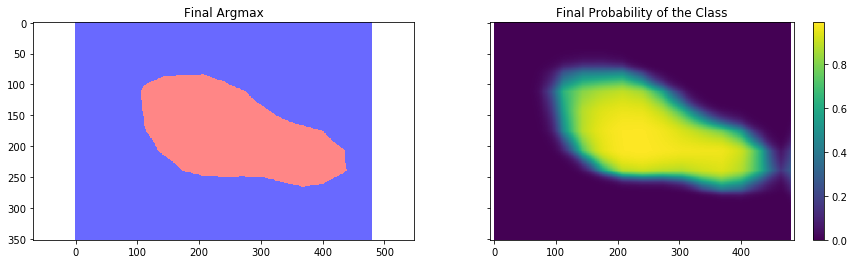

Final Loss: 20020.6


In [3]:
import numpy as np
import tensorflow as tf
import sys
import os
from matplotlib import pyplot as plt

fig_size = [15, 4]
plt.rcParams["figure.figsize"] = fig_size

import urllib2

slim = tf.contrib.slim

from nets import vgg
from preprocessing import vgg_preprocessing

# Load the mean pixel values and the function
# that performs the subtraction from each pixel
from preprocessing.vgg_preprocessing import (_mean_image_subtraction,
                                            _R_MEAN, _G_MEAN, _B_MEAN)

upsample_factor = 32
number_of_classes = 2
log_folder = '/home/tingwei/All/Machine_Learning/FCN_TUT/log_folder'

vgg_checkpoint_path = os.path.join(checkpoints_dir, 'vgg_16.ckpt')

# Convert image to float32 before subtracting the
# mean pixel value
image_float = tf.to_float(image_tensor, name='ToFloat')

# Subtract the mean pixel value from each pixel
mean_centered_image = _mean_image_subtraction(image_float,
                                          [_R_MEAN, _G_MEAN, _B_MEAN])

processed_images = tf.expand_dims(mean_centered_image, 0)

upsample_filter_np = bilinear_upsample_weights(upsample_factor,
                                               number_of_classes)

upsample_filter_tensor = tf.constant(upsample_filter_np)

# Define the model that we want to use -- specify to use only two classes at the last layer
with slim.arg_scope(vgg.vgg_arg_scope()):
    
    logits, end_points = vgg.vgg_16(processed_images,
                           num_classes=2,
                           is_training=is_training_placeholder,
                           spatial_squeeze=False,
                           fc_conv_padding='SAME')

downsampled_logits_shape = tf.shape(logits)

# Calculate the ouput size of the upsampled tensor
upsampled_logits_shape = tf.stack([
                                  downsampled_logits_shape[0],
                                  downsampled_logits_shape[1] * upsample_factor,
                                  downsampled_logits_shape[2] * upsample_factor,
                                  downsampled_logits_shape[3]
                                 ])

# Perform the upsampling
upsampled_logits = tf.nn.conv2d_transpose(logits, upsample_filter_tensor,
                                 output_shape=upsampled_logits_shape,
                                 strides=[1, upsample_factor, upsample_factor, 1])

# Flatten the predictions, so that we can compute cross-entropy for
# each pixel and get a sum of cross-entropies.
flat_logits = tf.reshape(tensor=upsampled_logits, shape=(-1, number_of_classes))

cross_entropies = tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits,
                                                          labels=flat_labels)

cross_entropy_sum = tf.reduce_sum(cross_entropies)

# Tensor to get the final prediction for each pixel -- pay 
# attention that we don't need softmax in this case because
# we only need the final decision. If we also need the respective
# probabilities we will have to apply softmax.
pred = tf.argmax(upsampled_logits, dimension=3)

probabilities = tf.nn.softmax(upsampled_logits)

# Here we define an optimizer and put all the variables
# that will be created under a namespace of 'adam_vars'.
# This is done so that we can easily access them later.
# Those variables are used by adam optimizer and are not
# related to variables of the vgg model.

# We also retrieve gradient Tensors for each of our variables
# This way we can later visualize them in tensorboard.
# optimizer.compute_gradients and optimizer.apply_gradients
# is equivalent to running:
# train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cross_entropy_sum)
with tf.variable_scope("adam_vars"):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    gradients = optimizer.compute_gradients(loss=cross_entropy_sum)
    
    for grad_var_pair in gradients:
        
        current_variable = grad_var_pair[1]
        current_gradient = grad_var_pair[0]
        
        # Relace some characters from the original variable name
        # tensorboard doesn't accept ':' symbol
        gradient_name_to_save = current_variable.name.replace(":", "_")
        
        # Let's get histogram of gradients for each layer and
        # visualize them later in tensorboard
        tf.summary.histogram(gradient_name_to_save, current_gradient) 
    
    train_step = optimizer.apply_gradients(grads_and_vars=gradients)
    
# Now we define a function that will load the weights from VGG checkpoint
# into our variables when we call it. We exclude the weights from the last layer
# which is responsible for class predictions. We do this because 
# we will have different number of classes to predict and we can't
# use the old ones as an initialization.
vgg_except_fc8_weights = slim.get_variables_to_restore(exclude=['vgg_16/fc8', 'adam_vars'])

# Here we get variables that belong to the last layer of network.
# As we saw, the number of classes that VGG was originally trained on
# is different from ours -- in our case it is only 2 classes.
vgg_fc8_weights = slim.get_variables_to_restore(include=['vgg_16/fc8'])

adam_optimizer_variables = slim.get_variables_to_restore(include=['adam_vars'])

# Add summary op for the loss -- to be able to see it in
# tensorboard.
tf.summary.scalar('cross_entropy_loss', cross_entropy_sum)

# Put all summary ops into one op. Produces string when
# you run it.
merged_summary_op = tf.summary.merge_all()

# Create the summary writer -- to write all the logs
# into a specified file. This file can be later read
# by tensorboard.
summary_string_writer = tf.summary.FileWriter(log_folder)

# Create the log folder if doesn't exist yet
if not os.path.exists(log_folder):
    os.makedirs(log_folder)

# Create an OP that performs the initialization of
# values of variables to the values from VGG.
read_vgg_weights_except_fc8_func = slim.assign_from_checkpoint_fn(
                                   vgg_checkpoint_path,
                                   vgg_except_fc8_weights)

# Initializer for new fc8 weights -- for two classes.
vgg_fc8_weights_initializer = tf.variables_initializer(vgg_fc8_weights)

# Initializer for adam variables
optimization_variables_initializer = tf.variables_initializer(adam_optimizer_variables)

with tf.Session() as sess:
    
    # Run the initializers.
    read_vgg_weights_except_fc8_func(sess)
    sess.run(vgg_fc8_weights_initializer)
    sess.run(optimization_variables_initializer)
    
    train_image, train_annotation = sess.run([image_tensor, annotation_tensor],
                                              feed_dict=feed_dict_to_use)
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(train_image)
    ax1.set_title('Input image')
    probability_graph = ax2.imshow(np.dstack((train_annotation,)*3)*100)
    ax2.set_title('Input Ground-Truth Annotation')
    plt.show()
    
    # Let's perform 10 interations
    for i in range(10):
        
        loss, summary_string = sess.run([cross_entropy_sum, merged_summary_op],
                                        feed_dict=feed_dict_to_use)
        
        sess.run(train_step, feed_dict=feed_dict_to_use)
        
        pred_np, probabilities_np = sess.run([pred, probabilities],
                                              feed_dict=feed_dict_to_use)
        
        summary_string_writer.add_summary(summary_string, i)
        
        cmap = plt.get_cmap('bwr')
        
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        ax1.imshow(np.uint8(pred_np.squeeze() != 1), vmax=1.5, vmin=-0.4, cmap=cmap)
        ax1.set_title('Argmax. Iteration # ' + str(i))
        probability_graph = ax2.imshow(probabilities_np.squeeze()[:, :, 0])
        ax2.set_title('Probability of the Class. Iteration # ' + str(i))
        
        plt.colorbar(probability_graph)
        plt.show()
        
        print("Current Loss: " +  str(loss))
    
    feed_dict_to_use[is_training_placeholder] = False
    
    final_predictions, final_probabilities, final_loss = sess.run([pred,
                                                                   probabilities,
                                                                   cross_entropy_sum],
                                                         feed_dict=feed_dict_to_use)
    
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    ax1.imshow(np.uint8(final_predictions.squeeze() != 1),
               vmax=1.5,
               vmin=-0.4,
               cmap=cmap)
    
    ax1.set_title('Final Argmax')
    
    
    probability_graph = ax2.imshow(final_probabilities.squeeze()[:, :, 0])
    ax2.set_title('Final Probability of the Class')
    plt.colorbar(probability_graph)
    
    plt.show()
    
    print("Final Loss: " +  str(final_loss))
    
    
    

summary_string_writer.close()